<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Web APIs & NLP

# 3_Data Cleaning, Exploratory Data Analysis & Vectorization

## Importing Libraries & Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 5, 4
sns.set_style('whitegrid')

import re
import string
import nltk
import gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
stopwords = nltk.corpus.stopwords.words("english")
wn = nltk.WordNetLemmatizer()

C:\Users\PIZZAFEAST\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# import scraped data for cleaning 
stocks = pd.read_csv("../data/extracted/stocks_text.csv")
crypto = pd.read_csv("../data/extracted/crypto_text.csv")

In [3]:
# merge both data files 
data = stocks.append(crypto, ignore_index=True)

# concatenate contents in the title and selftext columns and drop original columns
data["text"] = data["title"] + " " + data["selftext"]
data.drop(columns=["title", "selftext"], axis=1, inplace=True)

# rename column title 
data.rename(columns={"subreddit": "subreddit_class"}, inplace=True)

# check shape of merge dataframe
print(data.shape)

(3400, 3)


In [4]:
# check datatypes and confirm there are no null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit_class  3400 non-null   object
 1   created_utc      3400 non-null   int64 
 2   text             3400 non-null   object
dtypes: int64(1), object(2)
memory usage: 79.8+ KB


## Data Cleaning 
Remove punctuations, tokenize, remove stopwords and lemmatize

In [5]:
def clean_text(text):
    
    # remove unicode characters 
    text = text.encode('ascii', 'ignore').decode()
    
    # remove references to subreddits, e.g. "r/"WallStreetBets, numbers and http links
    text= re.sub(r"r/", "", text)
    text = re.sub(r"\w*\d+\w*", "", text)
    text= re.sub(r"http\S+", "", text)

    # remove punctuations, tokenize, remove stopwords and lemmatize 
    ## we use lemmatization instead of stemming as it tends to be more accurate
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text) 
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]

    return text

In [6]:
def clean_sentence(text):
    
    # remove unicode characters 
    text = text.encode('ascii', 'ignore').decode()
    
    # remove references to subreddits, e.g. "r/"WallStreetBets, numbers and http links
    text= re.sub(r"r/", "", text)
    text = re.sub(r"\w*\d+\w*", "", text)
    text= re.sub(r"http\S+", "", text)

    # remove punctuations and tokenize 
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text) 
    
    # apply lemmatization and stopwords exclusion within the same step
    # join tokens to form a full sentence as output
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopwords])

    return text

In [7]:
# apply function to clean text  
data["cleaned_text"] = data["text"].apply(lambda x: clean_text(x))
data["cleaned_sentence"] = data["text"].apply(lambda x: clean_sentence(x))

data.head()

,subreddit_class,created_utc,text,cleaned_text,cleaned_sentence
0,stocks,1626851004,Advise on Long Term Stock? I am earning very l...,"[advise, long, term, stock, earning, little, m...",advise long term stock earning little moment w...
1,stocks,1626847423,Dad told me to sell on Monday when the market ...,"[dad, told, sell, monday, market, red, bc, alr...",dad told sell monday market red bc already pro...
2,stocks,1626846017,Merger/accusation question about a game co. An...,"[mergeaccusation, question, game, co, theater,...",mergeaccusation question game co theater co re...
3,stocks,1626845812,Best Software to Track Trades and Create Repor...,"[best, software, track, trade, create, report,...",best software track trade create report hi im ...
4,stocks,1626840162,"After Driving My Friends Tesla, Here Are My Th...","[driving, friend, tesla, thought, bullish, tes...",driving friend tesla thought bullish tesla im ...


## Exploratory Data Analysis 
---
## Character and word count of original posts
We explore the post lengths to check if there are any stark difference(s) for both subreddits based on character and word count.

In [8]:
pd.to_datetime(1627391742, unit="s")

Timestamp('2021-07-27 13:15:42')

In [9]:
# create new column with character count
data["char_count"] = data["text"].apply(lambda x: len(x))

# define function to count words
def word_count(text):
    tokens = re.split('\W+', text) 
    return len(tokens)

# create new column with word count
data["word_count"] = data["text"].apply(lambda x: word_count(x))

# print first 5 rows of dataset
data.head()

,subreddit_class,created_utc,text,cleaned_text,cleaned_sentence,char_count,word_count
0,stocks,1626851004,Advise on Long Term Stock? I am earning very l...,"[advise, long, term, stock, earning, little, m...",advise long term stock earning little moment w...,297,59
1,stocks,1626847423,Dad told me to sell on Monday when the market ...,"[dad, told, sell, monday, market, red, bc, alr...",dad told sell monday market red bc already pro...,680,140
2,stocks,1626846017,Merger/accusation question about a game co. An...,"[mergeaccusation, question, game, co, theater,...",mergeaccusation question game co theater co re...,451,85
3,stocks,1626845812,Best Software to Track Trades and Create Repor...,"[best, software, track, trade, create, report,...",best software track trade create report hi im ...,1088,204
4,stocks,1626840162,"After Driving My Friends Tesla, Here Are My Th...","[driving, friend, tesla, thought, bullish, tes...",driving friend tesla thought bullish tesla im ...,663,137


### The median posts in r/CryptoCurrency tend to be longer, but the posts in r/stocks are longer on average. The dataset is suitable for NLP analysis as there are at least 10 words in each post.

In [10]:
# check summary statistics to compare post length for both subreddits (in terms of word count)
# there is at least 10 words in each post for NLP analysis 
data.groupby(by="subreddit_class").describe()["word_count"].round(2)

,count,mean,std,min,25%,50%,75%,max
subreddit_class,,,,,,,,
CryptoCurrency,1700.0,168.93,177.41,13.0,75.0,110.5,192.0,2225.0
stocks,1700.0,219.05,371.66,10.0,71.0,107.0,193.0,4313.0


In [11]:
# check summary statistics to compare post length for both subreddits (in terms of character count)
data.groupby(by="subreddit_class").describe()["char_count"].round(2)

,count,mean,std,min,25%,50%,75%,max
subreddit_class,,,,,,,,
CryptoCurrency,1700.0,919.29,1013.77,58.0,391.75,583.0,1031.75,12934.0
stocks,1700.0,1239.31,2200.23,46.0,373.00,572.5,1046.75,25724.0


### According to the boxplots, post lengths in both subreddits seem to be similar.

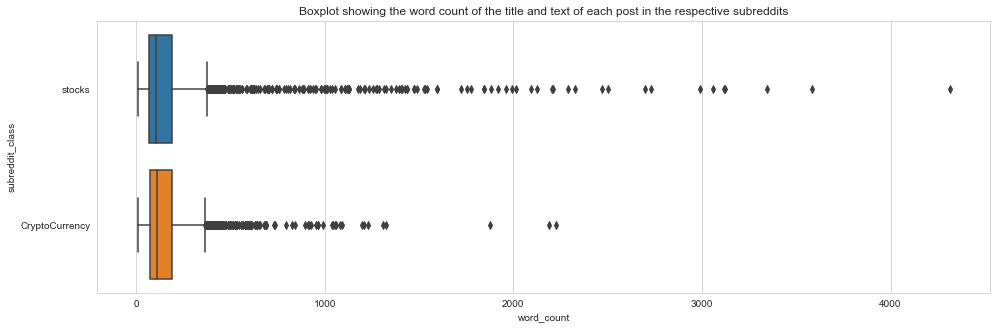

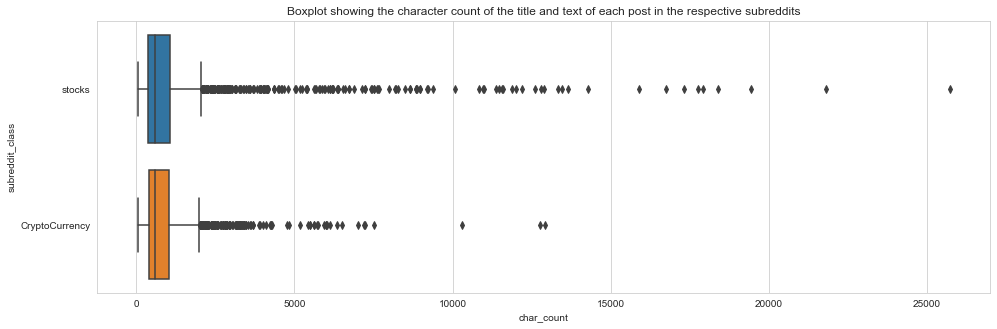

In [12]:
# draw a box plot showing the range of character and word counts for posts in both subreddits
fig, ax = plt.subplots(figsize=(16,5))
plt.title("Boxplot showing the word count of the title and text of each post in the respective subreddits")
sns.boxplot(y="subreddit_class", x="word_count", data=data)

fig, ax = plt.subplots(figsize=(16,5))
plt.title("Boxplot showing the character count of the title and text of each post in the respective subreddits")
sns.boxplot(y="subreddit_class", x="char_count", data=data);

### The subreddits' post lengths follow a highly right-skewed normal distribution with a long tail.

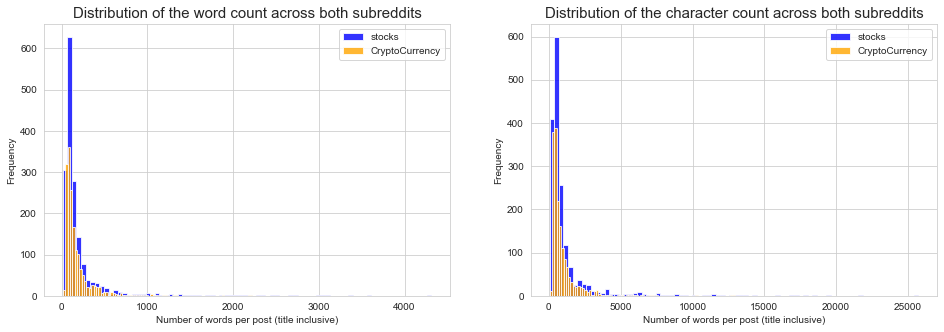

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].hist(data.loc[data["subreddit_class"]=="stocks"]["word_count"], bins=80, alpha=0.8, color='b', label="stocks")
ax[0].hist(data.loc[data["subreddit_class"]=="CryptoCurrency"]["word_count"], bins=80, alpha=0.8, color='orange', label="CryptoCurrency")

ax[0].set_title("Distribution of the word count across both subreddits", fontsize=15)
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Number of words per post (title inclusive)")
ax[0].legend()

ax[1].hist(data.loc[data["subreddit_class"]=="stocks"]["char_count"], bins=80, alpha=0.8, color='b', label="stocks")
ax[1].hist(data.loc[data["subreddit_class"]=="CryptoCurrency"]["char_count"], bins=80, alpha=0.8, color='orange', label="CryptoCurrency")

ax[1].set_title("Distribution of the character count across both subreddits", fontsize=15)
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("Number of words per post (title inclusive)")
ax[1].legend();

## Hour of posting

Next, we engineer a new feature called `hour_posted` to explore if there are any trends in terms of post creation timings across both subreddits. 

In [14]:
# create new data column to indicate the hour (i.e. 0h to 23h) during which the post was created 
data["hour_posted"] = data["created_utc"].apply(lambda utc: pd.to_datetime(utc, unit='s').hour)
data.head()

,subreddit_class,created_utc,text,cleaned_text,cleaned_sentence,char_count,word_count,hour_posted
0,stocks,1626851004,Advise on Long Term Stock? I am earning very l...,"[advise, long, term, stock, earning, little, m...",advise long term stock earning little moment w...,297,59,7
1,stocks,1626847423,Dad told me to sell on Monday when the market ...,"[dad, told, sell, monday, market, red, bc, alr...",dad told sell monday market red bc already pro...,680,140,6
2,stocks,1626846017,Merger/accusation question about a game co. An...,"[mergeaccusation, question, game, co, theater,...",mergeaccusation question game co theater co re...,451,85,5
3,stocks,1626845812,Best Software to Track Trades and Create Repor...,"[best, software, track, trade, create, report,...",best software track trade create report hi im ...,1088,204,5
4,stocks,1626840162,"After Driving My Friends Tesla, Here Are My Th...","[driving, friend, tesla, thought, bullish, tes...",driving friend tesla thought bullish tesla im ...,663,137,4


### There are typically more posts created in r/stocks than r/CryptoCurrency during the wee hours in the U.S.

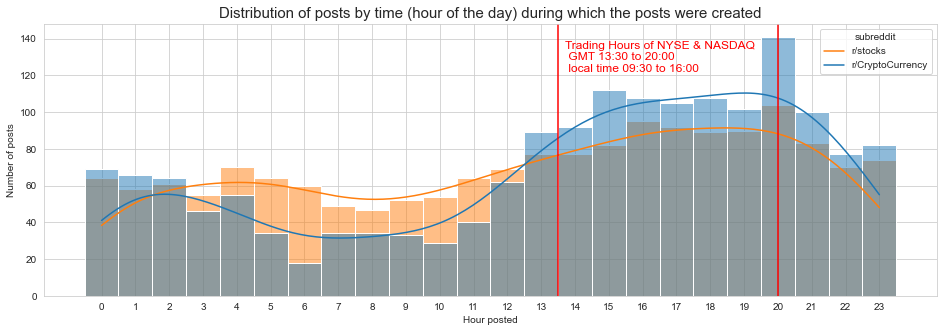

In [15]:
# create a histogram plot to display the frequency of post creation across the various hours within each day
plt.figure(figsize=(16,5))
plt.title("Distribution of posts by time (hour of the day) during which the posts were created", fontsize=15)
ax = sns.histplot(x="hour_posted", hue="subreddit_class", data=data, kde=True, bins=24, discrete=True, legend=False)
plt.legend(title='subreddit', loc='upper right', labels=['r/stocks', 'r/CryptoCurrency'])
ax.set_ylabel("Number of posts")
ax.set_xlabel("Hour posted")
ax.axvline(13.5, color="r")
ax.axvline(20, color="r")
ax.text(13.7, 122, "Trading Hours of NYSE & NASDAQ \n GMT 13:30 to 20:00 \n local time 09:30 to 16:00", 
        size='large', color='r')
ax.set_xticks(np.arange(0,24,1)); 

### The histogram plot above suggests that some observable difference in trends, in terms of hours during which the subreddit posts were created for r/stocks and r/CryptoCurrency. 

### However, the heatmap (of correlation matrix) below shows that there are weak correlation between this feature and the target variable (i.e. absolute value < 0.2). As such, we will drop this feature from model.

In [16]:
# create dummy variables for categorical data (i.e. hour_posted)
hours_dummy = pd.get_dummies(data["hour_posted"], prefix="hour_posted", drop_first=True)
stocks_dummy = pd.get_dummies(data["subreddit_class"], drop_first=True)
hours_df = pd.concat([hours_dummy, stocks_dummy], axis=1)
hours_df.head()

,hour_posted_1,hour_posted_2,hour_posted_3,hour_posted_4,hour_posted_5,hour_posted_6,hour_posted_7,hour_posted_8,hour_posted_9,hour_posted_10,...,hour_posted_15,hour_posted_16,hour_posted_17,hour_posted_18,hour_posted_19,hour_posted_20,hour_posted_21,hour_posted_22,hour_posted_23,stocks
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


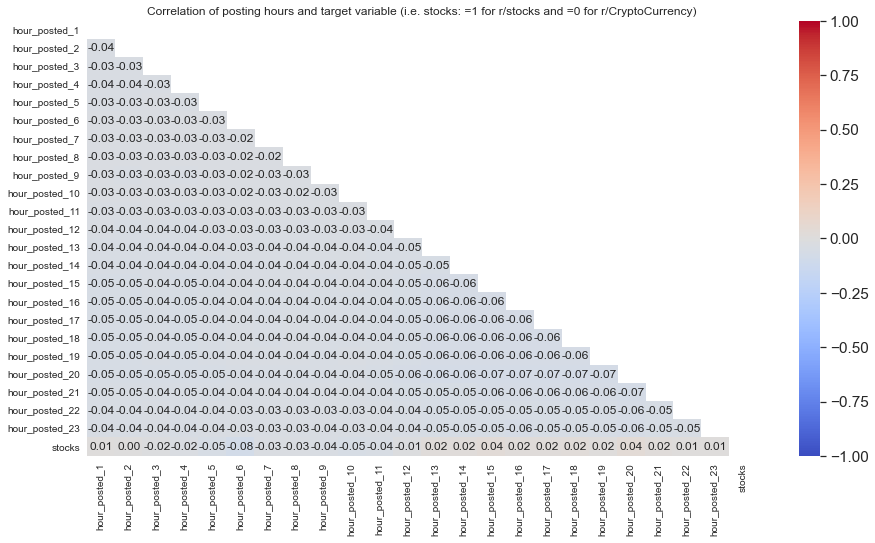

In [17]:
# plot a heatmap to look at the correlation matrix of the selected variables
# getting the Upper Triangle of the co-relation matrix
matrix = np.triu(hours_df.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,8))
plt.title("Correlation of posting hours and target variable (i.e. stocks: =1 for r/stocks and =0 for r/CryptoCurrency)")
sns.set(font_scale=1.4)
sns.heatmap(hours_df.corr(), annot=True, mask= matrix, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

## Word Vectorization

Vectorize text data to study which are the words that are most related to "stock" and "crypto" (i.e. most frequently occuring word in the respective subreddits). 

In [18]:
# train the word2vec model
# set window = 5; 5 words before and after the focus word that will be considered as context
# set min_count = 2 to ignore outliers; only words that appear at least twice in our corpus will be vectorized
text = data["cleaned_text"]
w2v_model = gensim.models.Word2Vec(text, window=5, min_count=2)

In [19]:
print(w2v_model.wv.index_to_key)

['stock', 'market', 'price', 'crypto', 'company', 'like', 'im', 'year', 'would', 'time', 'buy', 'one', 'people', 'dont', 'share', 'money', 'know', 'get', 'coin', 'new', 'also', 'make', 'think', 'see', 'day', 'good', 'month', 'amp', 'go', 'even', 'could', 'going', 'want', 'week', 'u', 'much', 'last', 'still', 'way', 'sell', 'well', 'around', 'ive', 'long', 'trading', 'back', 'growth', 'may', 'many', 'first', 'right', 'since', 'use', 'thing', 'high', 'post', 'lot', 'value', 'say', 'take', 'need', 'bitcoin', 'really', 'investment', 'looking', 'look', 'btc', 'currently', 'today', 'target', 'next', 'million', 'earnings', 'buying', 'short', 'let', 'term', 'investor', 'said', 'revenue', 'cash', 'bank', 'account', 'every', 'financial', 'future', 'portfolio', 'invest', 'question', 'wallet', 'thought', 'anyone', 'investing', 'gt', 'rate', 'better', 'profit', 'something', 'current', 'big', 'bear', 'point', 'bought', 'dip', 'come', 'eth', 'thats', 'work', 'project', 'put', 'keep', 'help', 'moon', 

In [20]:
# Find the most similar words to "stocks" based on word vectors from our trained model
w2v_model.wv.most_similar('stock')

[('dip', 0.9695724844932556),
 ('buying', 0.9528583884239197),
 ('drop', 0.937511146068573),
 ('sell', 0.9368525743484497),
 ('eth', 0.9342858791351318),
 ('go', 0.9318520426750183),
 ('buy', 0.9310925006866455),
 ('selling', 0.9308645725250244),
 ('btc', 0.9255219101905823),
 ('hold', 0.9188987016677856)]

In [21]:
# Find the most similar words to "crypto" based on word vectors from our trained model
w2v_model.wv.most_similar('crypto')

[('investing', 0.9841346144676208),
 ('best', 0.9826931953430176),
 ('curious', 0.9759864807128906),
 ('everyone', 0.975479006767273),
 ('hope', 0.9741718173027039),
 ('wondering', 0.972716212272644),
 ('hi', 0.9725604057312012),
 ('guy', 0.970873236656189),
 ('hello', 0.9708442687988281),
 ('hey', 0.9697821736335754)]

### Cryptocurrencies such as`btc` and `eth` are considered words that are highly related to `stock`. This suggests that it may be challenging to classify posts' membership in the r/stocks and r/CryptoCurrency subreddits based on textual data as the words are closely related.

## Count Vectorization (EDA & Pre-processing)

We pre-process and convert text data into a structured, numeric dataframe by using the `CountVectorizer`.

- **Count**: Count up how many times a token is observed in a given document.
- **Vectorizer**: Create a column (also known as a vector) that stores those counts.

In [22]:
# instantiate a CountVectorizer, include clean_text function as the analyzer
# set min_df=2 to ignore outliers so that only words that appear at least twice in the corpus will be vectorised
cvec = CountVectorizer(analyzer=clean_text, min_df=2)

# fit the vectorizer on our corpus; X_cvec stores the vectorised data
X_cvec = cvec.fit_transform(data["text"])

# returns the number of rows and columns of X_cvec
print(X_cvec.shape) # there are 3,400 posts and 10,272 unique words 

# returns the unique words across alll text messages
print(cvec.get_feature_names())

(3400, 10272)
['', 'aa', 'aaa', 'aaii', 'aal', 'aapl', 'aapls', 'aaron', 'aave', 'abandon', 'abandoned', 'abandoning', 'abbv', 'abbvie', 'abc', 'abcl', 'ability', 'able', 'abnb', 'abo', 'aboard', 'abra', 'abraham', 'abroad', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorbed', 'abstract', 'absurdly', 'abt', 'abundance', 'abundant', 'abuse', 'academic', 'academy', 'acc', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accelerator', 'accenture', 'accept', 'acceptability', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessible', 'accident', 'accidentally', 'accommodate', 'accompanied', 'accomplish', 'accomplishment', 'accordance', 'according', 'accordingly', 'account', 'accountable', 'accountant', 'accounted', 'accounting', 'accredited', 'accross', 'accrue', 'acct', 'accumulate', 'accumulated', 'accumulating', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accusation', 'accused', 'ace', 'ach'

In [23]:
# Due to the nature of sparse matrices where only non-zero elements are stored, 
# we expand it out to a collection of arrays and store it in a data frame
X_cvec_df = pd.DataFrame(X_cvec.toarray())
X_cvec_df.columns = cvec.get_feature_names()
X_cvec_df.head()

,,aa,aaa,aaii,aal,aapl,aapls,aaron,aave,abandon,...,zilliqa,zillows,zim,zinc,zm,zone,zoo,zoom,zooming,zscaler
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# merge vectorized dataset with original data fields
count_df = pd.concat([data, X_cvec_df], axis=1)
count_df.head()

,subreddit_class,created_utc,text,cleaned_text,cleaned_sentence,char_count,word_count,hour_posted,,aa,...,zilliqa,zillows,zim,zinc,zm,zone,zoo,zoom,zooming,zscaler
0,stocks,1626851004,Advise on Long Term Stock? I am earning very l...,"[advise, long, term, stock, earning, little, m...",advise long term stock earning little moment w...,297,59,7,0,0,...,0,0,0,0,0,0,0,0,0,0
1,stocks,1626847423,Dad told me to sell on Monday when the market ...,"[dad, told, sell, monday, market, red, bc, alr...",dad told sell monday market red bc already pro...,680,140,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2,stocks,1626846017,Merger/accusation question about a game co. An...,"[mergeaccusation, question, game, co, theater,...",mergeaccusation question game co theater co re...,451,85,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,stocks,1626845812,Best Software to Track Trades and Create Repor...,"[best, software, track, trade, create, report,...",best software track trade create report hi im ...,1088,204,5,0,0,...,0,0,0,0,0,0,0,0,0,0
4,stocks,1626840162,"After Driving My Friends Tesla, Here Are My Th...","[driving, friend, tesla, thought, bullish, tes...",driving friend tesla thought bullish tesla im ...,663,137,4,0,0,...,0,0,0,0,0,0,0,0,0,0


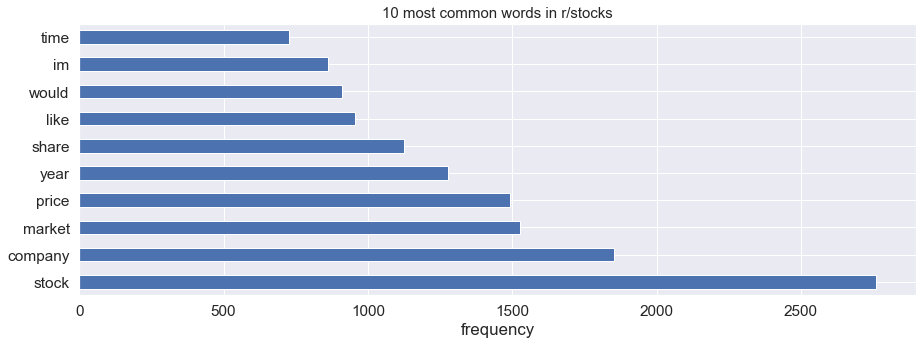

In [25]:
plt.figure(figsize=(15,5))
plt.title("10 most common words in r/stocks", fontsize=15)
plt.xlabel("frequency")
count_df.iloc[0:1700, 8::].sum().sort_values(ascending=False).head(10).plot(kind='barh');

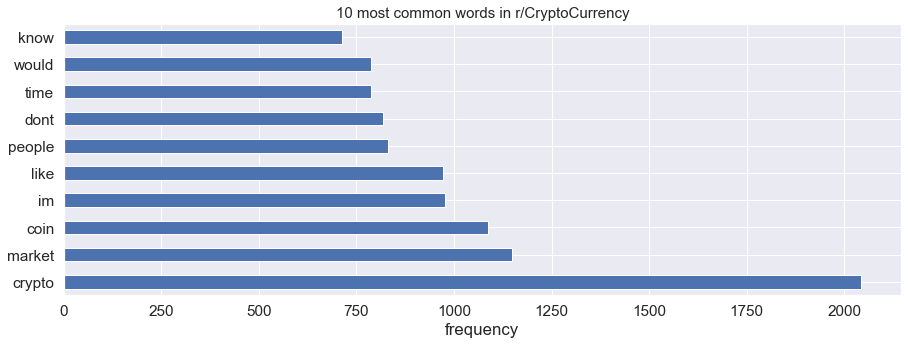

In [26]:
plt.figure(figsize=(15,5))
plt.title("10 most common words in r/CryptoCurrency", fontsize=15)
plt.xlabel("frequency")
count_df.iloc[1701::, 8::].sum().sort_values(ascending=False).head(10).plot(kind='barh');

### The most common words tended to have a higher correlation with the target variable.

In [27]:
# create a dataframe with the target variable and the 5 most common words in the respective subreddit
df = count_df[["crypto", "market", "coin", "im", "like", 
               "stock", "company", "price", "year",
               "subreddit_class"]]

# dummify target variable: 1 = stocks, 0 = cryptocurrency
dummify = {"stocks":1, "CryptoCurrency":0}
df["subreddit_class"] = df["subreddit_class"].map(dummify);

<ipython-input-27-5d349abd4103>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subreddit_class"] = df["subreddit_class"].map(dummify);


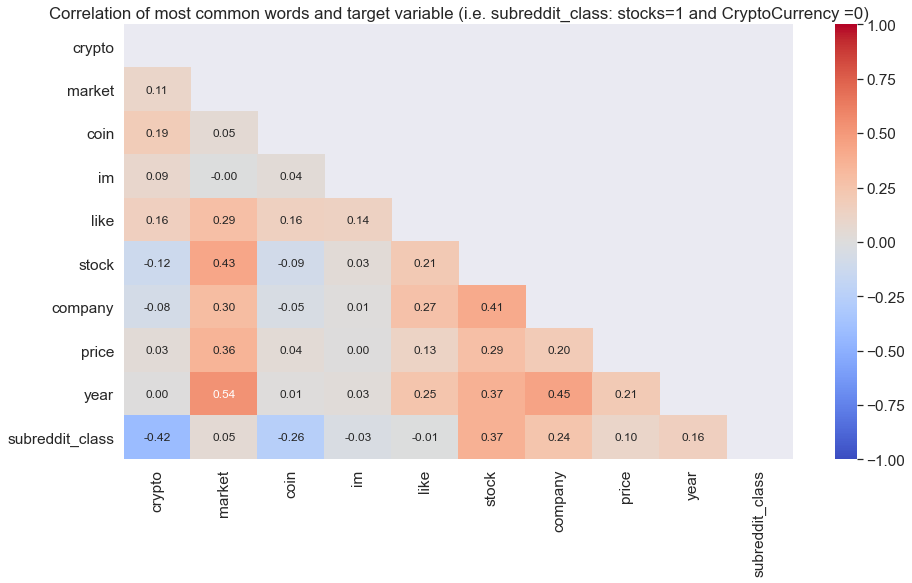

In [28]:
# plot a heatmap to look at the correlation matrix of the selected variables
# getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,8))
plt.title("Correlation of most common words and target variable (i.e. subreddit_class: stocks=1 and CryptoCurrency =0)")
sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, mask= matrix, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

## CountVectorizer with N-Grams

Next, we further apply n-gram to look at word pairs in the dataset for exploratory data analysis.

In [29]:
# ngram_range refers to the range of n-grams that we would like to look for
# indicate (2,2) = bigrams as we are interested to study word-pairs
# set min_df=2 to ignore outliers so that only words that appear at least twice in the corpus will be vectorised
ngram_vect = CountVectorizer(ngram_range=(2,2), min_df=2)
count_2gram = ngram_vect.fit_transform(data["cleaned_sentence"])

# Data Set has 35,145 unique 2-word combinations
print(count_2gram.shape)

# returns the unique words across alll text messages
print(ngram_vect.get_feature_names())

(3400, 35145)
['aaii survey', 'aapl account', 'aapl amzn', 'aapl android', 'aapl googl', 'aapl largest', 'aapl msft', 'aapl target', 'aapl vxus', 'aave aave', 'aave compound', 'aave metamask', 'ability buy', 'ability create', 'ability generate', 'ability get', 'ability perform', 'ability withstand', 'able access', 'able afford', 'able build', 'able buy', 'able claim', 'able come', 'able continue', 'able convert', 'able earn', 'able easily', 'able execute', 'able expand', 'able find', 'able fully', 'able get', 'able give', 'able given', 'able grow', 'able help', 'able hold', 'able invest', 'able keep', 'able live', 'able make', 'able move', 'able offer', 'able pay', 'able pick', 'able post', 'able predict', 'able provide', 'able pull', 'able put', 'able receive', 'able retire', 'able see', 'able sell', 'able spend', 'able sustain', 'able tell', 'able trade', 'able understand', 'able use', 'able vest', 'able walk', 'able withdraw', 'abo price', 'abra edge', 'abraham lincoln', 'abroad ele

In [30]:
# we expand sparse matrix out to a collection of arrays and store it in a data frame
count_2gram_df = pd.DataFrame(count_2gram.toarray())
count_2gram_df.columns = ngram_vect.get_feature_names()
count_2gram_df.head()

,aaii survey,aapl account,aapl amzn,aapl android,aapl googl,aapl largest,aapl msft,aapl target,aapl vxus,aave aave,...,zero sense,zero sum,zero tax,zero upvotes,zero would,zerosum game,zoo fomo,zoom little,zoom video,zscaler target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# merge vectorized dataset with original data fields
count_2gram_df = pd.concat([data, count_2gram_df], axis=1)
count_2gram_df.head()

,subreddit_class,created_utc,text,cleaned_text,cleaned_sentence,char_count,word_count,hour_posted,aaii survey,aapl account,...,zero sense,zero sum,zero tax,zero upvotes,zero would,zerosum game,zoo fomo,zoom little,zoom video,zscaler target
0,stocks,1626851004,Advise on Long Term Stock? I am earning very l...,"[advise, long, term, stock, earning, little, m...",advise long term stock earning little moment w...,297,59,7,0,0,...,0,0,0,0,0,0,0,0,0,0
1,stocks,1626847423,Dad told me to sell on Monday when the market ...,"[dad, told, sell, monday, market, red, bc, alr...",dad told sell monday market red bc already pro...,680,140,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2,stocks,1626846017,Merger/accusation question about a game co. An...,"[mergeaccusation, question, game, co, theater,...",mergeaccusation question game co theater co re...,451,85,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,stocks,1626845812,Best Software to Track Trades and Create Repor...,"[best, software, track, trade, create, report,...",best software track trade create report hi im ...,1088,204,5,0,0,...,0,0,0,0,0,0,0,0,0,0
4,stocks,1626840162,"After Driving My Friends Tesla, Here Are My Th...","[driving, friend, tesla, thought, bullish, tes...",driving friend tesla thought bullish tesla im ...,663,137,4,0,0,...,0,0,0,0,0,0,0,0,0,0


### `price target` is the most commonly occuring pair of words in r/stocks.

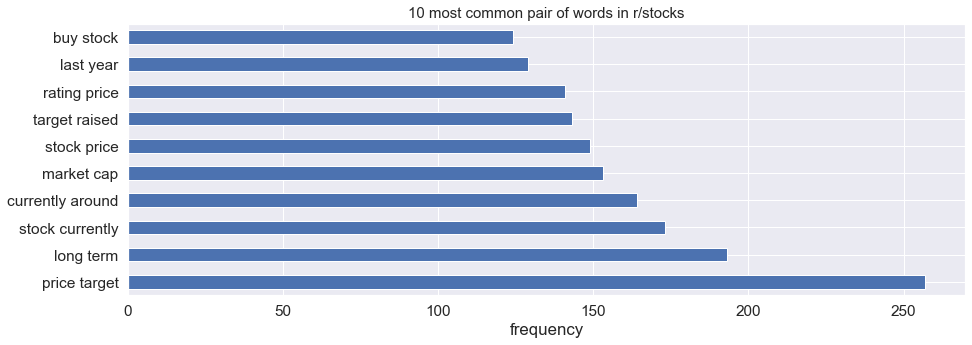

In [32]:
# create plot to visualise the most commonly occurring pair of words in r/stocks
plt.figure(figsize=(15,5))
plt.title("10 most common pair of words in r/stocks", fontsize=15)
plt.xlabel("frequency")
count_2gram_df.iloc[0:1700, 8::].sum().sort_values(ascending=False).head(10).plot(kind='barh');

### `bear market` is the most commonly occuring pair of words in r/CryptoCurrency in July 2021.

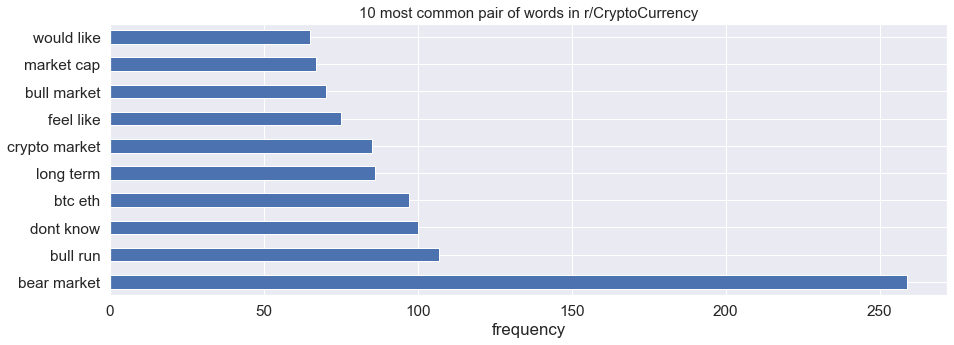

In [33]:
# create plot to visualise the most commonly occurring pair of words in r/CryptoCurrency
plt.figure(figsize=(15,5))
plt.title("10 most common pair of words in r/CryptoCurrency", fontsize=15)
plt.xlabel("frequency")
count_2gram_df.iloc[1701::, 8::].sum().sort_values(ascending=False).head(10).plot(kind='barh');

### The most common word-pairs tended to very low correlation with the target variable (i.e. absolute value < 0.2). This suggests that we can drop the n-gram vectorization method for modelling.

In [34]:
# create a dataframe with the target variable and the 3 most common word-pairs in the respective subreddits
df = count_2gram_df[["bear market", "bull run", "dont know", 
                     "price target", "long term", "stock currently",
                     "subreddit_class"]]

# dummify target variable: 1 = stocks, 0 = cryptocurrency
dummify = {"stocks":1, "CryptoCurrency":0}
df["subreddit_class"] = df["subreddit_class"].map(dummify);

<ipython-input-34-bc7f21f98d5c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subreddit_class"] = df["subreddit_class"].map(dummify);


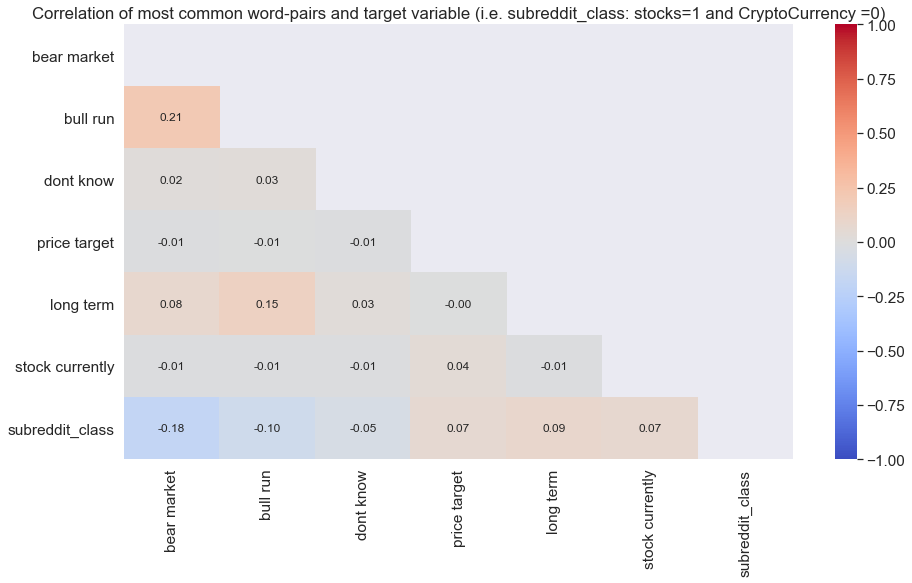

In [35]:
# plot a heatmap to look at the correlation matrix of the selected variables
# getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,8))
plt.title("Correlation of most common word-pairs and target variable (i.e. subreddit_class: stocks=1 and CryptoCurrency =0)")
sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, mask= matrix, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

## Pre-processing - TF-IDF

Lastly, we apply `TF-IDF` to vectorize the text data where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

In [36]:
# instantiate a TF-IDFVectorizer, include clean_text function as the analyzer
# set min_df=2 to ignore outliers so that only words that appear at least twice in the corpus will be vectorised
tfidf_vect = TfidfVectorizer(analyzer=clean_text, min_df=2)
X_tfidf = tfidf_vect.fit_transform(data['text'])

# Data Set has 10,272 unique words (same as CountVectorizer)
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(3400, 10272)
['', 'aa', 'aaa', 'aaii', 'aal', 'aapl', 'aapls', 'aaron', 'aave', 'abandon', 'abandoned', 'abandoning', 'abbv', 'abbvie', 'abc', 'abcl', 'ability', 'able', 'abnb', 'abo', 'aboard', 'abra', 'abraham', 'abroad', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorbed', 'abstract', 'absurdly', 'abt', 'abundance', 'abundant', 'abuse', 'academic', 'academy', 'acc', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accelerator', 'accenture', 'accept', 'acceptability', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessible', 'accident', 'accidentally', 'accommodate', 'accompanied', 'accomplish', 'accomplishment', 'accordance', 'according', 'accordingly', 'account', 'accountable', 'accountant', 'accounted', 'accounting', 'accredited', 'accross', 'accrue', 'acct', 'accumulate', 'accumulated', 'accumulating', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accusation', 'accused', 'ace', 'ach'

In [37]:
# we expand sparse matrix out to a collection of arrays and store it in a data frame
tfidf_df = pd.DataFrame(X_tfidf.toarray())
tfidf_df.columns = tfidf_vect.get_feature_names()
tfidf_df.head()

,,aa,aaa,aaii,aal,aapl,aapls,aaron,aave,abandon,...,zilliqa,zillows,zim,zinc,zm,zone,zoo,zoom,zooming,zscaler
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.451853,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# merge vectorized dataset with original data fields
tfidf_df = pd.concat([data, tfidf_df], axis=1)
tfidf_df.head()

,subreddit_class,created_utc,text,cleaned_text,cleaned_sentence,char_count,word_count,hour_posted,,aa,...,zilliqa,zillows,zim,zinc,zm,zone,zoo,zoom,zooming,zscaler
0,stocks,1626851004,Advise on Long Term Stock? I am earning very l...,"[advise, long, term, stock, earning, little, m...",advise long term stock earning little moment w...,297,59,7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,stocks,1626847423,Dad told me to sell on Monday when the market ...,"[dad, told, sell, monday, market, red, bc, alr...",dad told sell monday market red bc already pro...,680,140,6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,stocks,1626846017,Merger/accusation question about a game co. An...,"[mergeaccusation, question, game, co, theater,...",mergeaccusation question game co theater co re...,451,85,5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,stocks,1626845812,Best Software to Track Trades and Create Repor...,"[best, software, track, trade, create, report,...",best software track trade create report hi im ...,1088,204,5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,stocks,1626840162,"After Driving My Friends Tesla, Here Are My Th...","[driving, friend, tesla, thought, bullish, tes...",driving friend tesla thought bullish tesla im ...,663,137,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


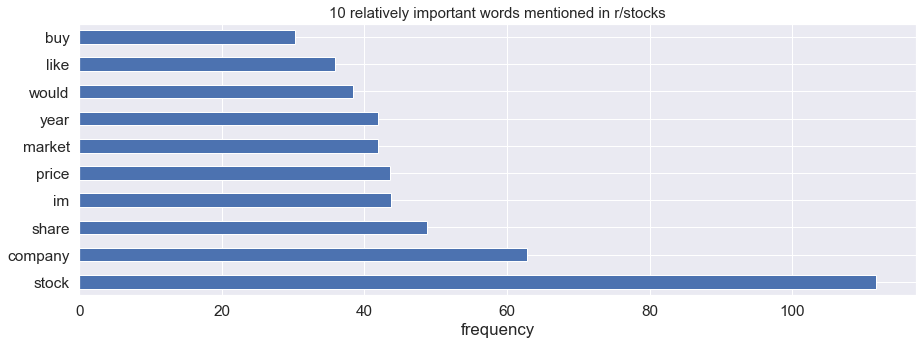

In [39]:
# create plot to visualise the relatively important words mentioned in r/stocks
plt.figure(figsize=(15,5))
plt.title("10 relatively important words mentioned in r/stocks", fontsize=15)
plt.xlabel("frequency")
tfidf_df.iloc[0:1700, 8::].sum().sort_values(ascending=False).head(10).plot(kind='barh');

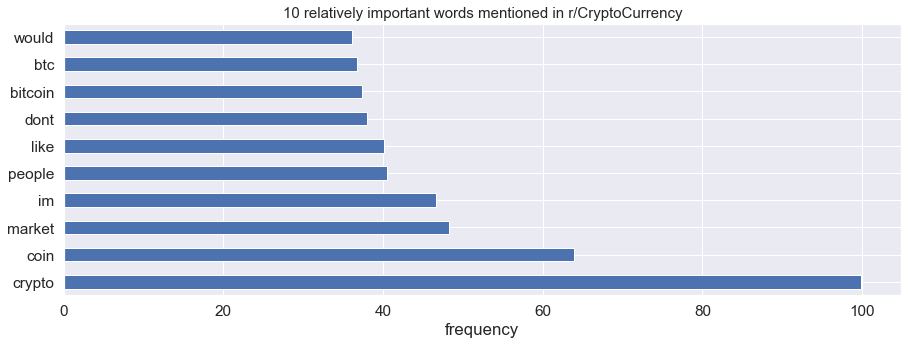

In [40]:
# create plot to visualise the relatively important words mentioned in r/CryptoCurrency
plt.figure(figsize=(15,5))
plt.title("10 relatively important words mentioned in r/CryptoCurrency", fontsize=15)
plt.xlabel("frequency")
tfidf_df.iloc[1701::, 8::].sum().sort_values(ascending=False).head(10).plot(kind='barh');

### Similar to the `CountVectorizer`, the most important words tended to have a higher correlation with the target. The magnitude of the correlation observed using `Tf-idfVectorizer` is similar to those produced using `CountVectorizer` (i.e. higher than count 2-gram vectorization).

In [41]:
# create a dataframe with the target variable and the 5 most important words in the respective subreddit
df = tfidf_df[["crypto", "market", "coin", "im", "people", 
               "stock", "company", "price", "im", "price",
               "subreddit_class"]]

# dummify target variable: 1 = stocks, 0 = cryptocurrency
dummify = {"stocks":1, "CryptoCurrency":0}
df["subreddit_class"] = df["subreddit_class"].map(dummify);

<ipython-input-41-156bc1bc4d04>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subreddit_class"] = df["subreddit_class"].map(dummify);


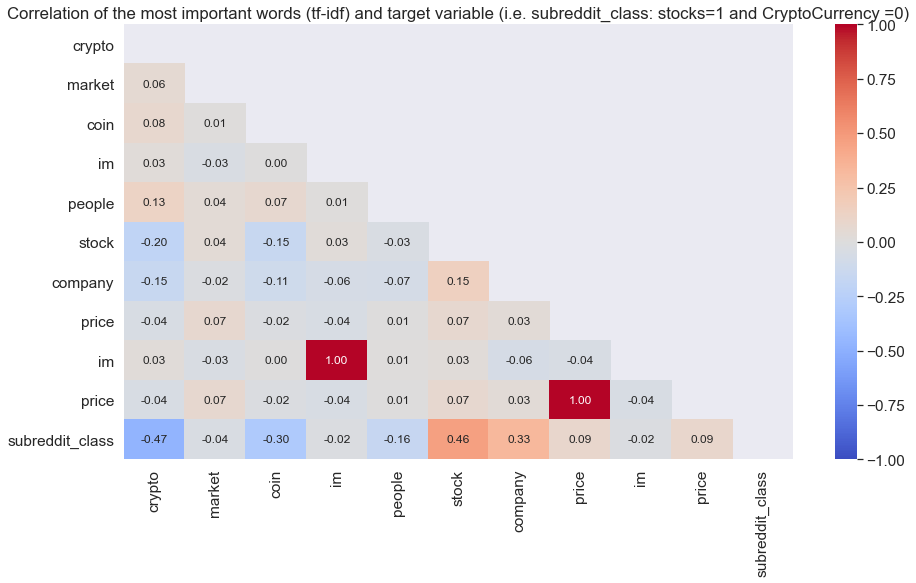

In [42]:
# plot a heatmap to look at the correlation matrix of the selected variables
# getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,8))
plt.title("Correlation of the most important words (tf-idf) and target variable (i.e. subreddit_class: stocks=1 and CryptoCurrency =0)")
sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, mask= matrix, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

## Export relevant datasets for modelling (i.e. vectorization by count & tf-idf)

In [ ]:
# since word pairs have weak correlation with target, 
# we proceed to model using only CountVectorized and Tf-idfVectorized data 
count_df.to_csv("../data/vectorized/count.csv", index=False)
tfidf_df.to_csv("../data/vectorized/tfidf.csv", index=False)